In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [5]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [6]:
all_data_sentence_index = all_data.set_index('sentence_id')

### More balanced sample

In [7]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [8]:
all_data_classes = list(all_data.groupby('class'))

In [9]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
3707902,287635,10,ADDRESS,C5,c five
7892390,602773,6,ADDRESS,U.S. 27,u s twenty seven
4012898,310718,3,CARDINAL,5,five
6703250,513453,18,CARDINAL,262,two hundred sixty two


In [10]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [11]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [12]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
3587508,278436,9,LETTERS,PDF,p d f
5752339,442159,6,DIGIT,01,o one
6087323,467387,14,PUNCT,.,.
8224815,627584,2,TELEPHONE,911,nine one one
7849761,599580,18,PUNCT,.,.
562963,45424,3,MEASURE,46%,forty six percent
6449587,494389,6,DATE,2000,two thousand
7835093,598485,18,DIGIT,1276,one two seven six
5784444,444551,9,CARDINAL,285,two hundred eighty five
6904240,528485,8,LETTERS,D,D


In [13]:
test = data_balanced_classes.sample(10)
test

,sentence_id,token_id,class,before,after
2833605,221054,7,DATE,1934,nineteen thirty four
5597801,430568,2,DIGIT,1947,one nine four seven
5920284,454832,11,DATE,1999,nineteen ninety nine
6168871,473453,4,LETTERS,d,d
8808440,670981,2,LETTERS,PDF,p d f
1529279,120881,9,PUNCT,",",","
6410901,491510,1,LETTERS,TV,t v
8954295,681910,5,DATE,2013-08-01,the first of august twenty thirteen
8900558,677849,17,PUNCT,.,.
9078618,691108,1,LETTERS,ISU,i s u


In [14]:
data_balanced_classes_matrix = data_balanced_classes.as_matrix()

In [15]:
%%timeit
data_balanced_classes.sample(1)

4.86 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
data_balanced_classes.iloc[random.randint(1, len(test)-1)]

98.4 µs ± 732 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
data_balanced_classes_matrix[random.randint(1, len(test)-1)]

2.03 µs ± 25.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Word vectors

In [18]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [19]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [20]:
wv_max_words = len(wv_words)
print("Original last word:", wv_words[wv_max_words - 1])

Original last word: sandberger


In [21]:
wv_vecs = np.concatenate((wv_vecs, np.zeros([1, 50], dtype=np.float32)), axis=0)
wv_words.append('SAMPLE')
wv_idx['SAMPLE'] = wv_words.index('SAMPLE')

In [22]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

In [23]:
arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

0.978

In [24]:
def get_random_sample():
    sample_row = data_balanced_classes.iloc[random.randint(1, len(data_balanced_classes)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '*****'
    str_list = simple_tokeniser(' '.join(befores))
    
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    # var = np.zeros((1, len(str_list), wv_vecs.shape[1]+1))
    for i, w in enumerate(str_list):
        if w=='*****':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return sample_row['before'], sample_row['after'], sample_row['class'], word_vect
            
# get_random_sample()
s_bef, s_aft, s_class, s_word_v = get_random_sample()
print(s_class, ':', s_bef, '->', s_aft, ':', s_word_v.shape, type(s_word_v[0,0,0]))

LETTERS : nr -> n r : (1, 5, 50) <class 'numpy.float32'>


In [25]:
%%timeit
get_random_sample()

500 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Categories and Chars

In [26]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'DECIMAL' 'MEASURE' 'MONEY'
 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE' 'ADDRESS']
15


In [32]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [36]:
def string_to_tensor(line):
    tensor = torch.zeros(1, len(line), letters_n)
    for li, letter in enumerate(line):
        tensor[0, li, letters_index[letter]] = 1
    return tensor
print(string_to_tensor('wordup').size())

torch.Size([1, 6, 112])


# Model

In [90]:
use_cuda = False

In [165]:
class RNN_WORDS_CHARS_CLASS(nn.Module):
    def __init__(self, wordvect_size, letters_size, hidden_size, output_size, n_layers=1):
        super(RNN_WORDS_CHARS_CLASS, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_words = nn.LSTM(wordvect_size, hidden_size, n_layers, batch_first=True)
        
        self.rnn_chars = nn.LSTM(letters_size, hidden_size, n_layers, batch_first=True)
        
        # self.lin_1 = nn.Linear(hidden_size*2, 1024)
        #self.lin_1 = nn.Linear(hidden_size, 1024)
        self.lin_output = nn.Linear(hidden_size*2, output_size)

    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        #TESTING HOW DOES THE WORDS AFFECT THIS
        #output = output_chars
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var1_2 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var2_1 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var2_2 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        if use_cuda:
            var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
            var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

use_cuda = False
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
s_string = string_to_tensor(s_bef)
model_tmp = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all))
print('Word vect size:', s_word_vs.shape, '. String vector size:', s_string.size())
output = model_tmp(Variable(torch.from_numpy(s_word_vs)), Variable(s_string))
print('Output:', output.size())

Word vect size: (1, 2, 50) . String vector size: torch.Size([1, 13, 112])
Output: torch.Size([1, 15])


In [166]:
use_cuda=True

In [92]:
tmp = use_cuda
use_cuda = True
model.cuda()
output = model(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_string).cuda())
use_cuda = tmp
type(output.data)

torch.cuda.FloatTensor

In [70]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(category_from_output(output))

('TIME', 9)


### Accuracy

In [96]:
use_cuda = True

In [99]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()
        s_string = Variable(string_to_tensor(s_bef))
        s_word_vs = Variable(torch.from_numpy(s_word_vs))
        if use_cuda:
            s_word_vs = s_word_vs.cuda()
            s_string = s_string.cuda()
        output = model(s_word_vs, s_string)
        if s_class == category_from_output(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

In [100]:
%%time
test_model_accuracy(model, n_sample=1000)

Accuracy: 17.60% (     176/    1000)
CPU times: user 2.02 s, sys: 12 ms, total: 2.03 s
Wall time: 2.03 s


# Training

In [160]:
def train(model, category, word_vectors, string):
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    word_vectors = Variable(torch.from_numpy(word_vectors))
    string = Variable(string_to_tensor(string))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        word_vectors = word_vectors.cuda()
        string = string.cuda()

    output = model(word_vectors, string)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [161]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
train(model, s_class, s_word_vs, s_bef)

(Variable containing:
 
 Columns 0 to 9 
 -1.7899 -1.5999 -1.7431 -1.7840 -1.8631 -3.8468 -3.2847 -4.5116 -3.4812 -6.1416
 
 Columns 10 to 14 
 -4.6041 -4.5043 -6.4336 -4.9500 -7.5641
 [torch.cuda.FloatTensor of size 1x15 (GPU 0)], 1.7899038791656494)

In [83]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [200]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    model.train()
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()

        output, loss = train(model, s_class, s_word_vs, s_bef)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == s_class else "✗ ({})".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                s_bef, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
    
    data_balance_randomize_classes()
    test_model_accuracy(model, n_sample=10000)
    return all_losses

In [167]:
model = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all)).cuda()
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=50000)

  5000  10% (  0m 21s)   0.39   |   0.01: . -> PUNCT ✓
 10000  20% (  0m 42s)   0.24   |   0.00: , -> PUNCT ✓
 15000  30% (   1m 3s)   0.23   |   0.34: Le -> PLAIN ✓
 20000  40% (  1m 24s)   0.17   |   0.00: SF -> LETTERS ✓
 25000  50% (  1m 45s)   0.17   |   0.04: 2007 -> DATE ✓
 30000  60% (   2m 6s)   0.17   |   0.00: . -> PUNCT ✓
 35000  70% (  2m 27s)   0.13   |   0.01: 460 -> CARDINAL ✓
 40000  80% (  2m 48s)   0.13   |   0.76: X -> LETTERS ✓
 45000  90% (   3m 9s)   0.10   |   0.01: 16 ha -> MEASURE ✓
 50000 100% (  3m 31s)   0.14   |   0.05: 78 kt -> MEASURE ✓
Accuracy: 96.14% (    9614/   10000)


In [169]:
all_losses_2 = train_iterations(n_iters=250000, start_iter=50000, print_every=25000)

 75000  10% (  1m 50s)   0.10   |   0.00: mentor -> PLAIN ✓
100000  20% (  3m 43s)   0.11   |   0.00: 2008-05-30 -> DATE ✓
125000  30% (  5m 29s)   0.07   |   0.01: Knoll -> PLAIN ✓
150000  40% (  7m 13s)   0.06   |   0.03: D -> LETTERS ✓
175000  50% (  8m 58s)   0.08   |   0.01: http://www.kickspeed.com.au/Improve-measure-kicking-speed.htmlhttp://www.wisil.recumbents.com/wisil/whpsc2009/results.htmDarling -> ELECTRONIC ✓
200000  60% ( 10m 42s)   0.08   |   0.00: 40 km -> MEASURE ✓
225000  70% ( 12m 27s)   0.05   |   0.00: School -> PLAIN ✓
250000  80% ( 14m 18s)   0.07   |   1.85: IV -> ORDINAL ✗ (LETTERS)
275000  90% (  16m 4s)   0.07   |   0.00: BD -> LETTERS ✓
300000 100% ( 17m 48s)   0.06   |   0.00: 14 -> CARDINAL ✓
Accuracy: 97.83% (    9783/   10000)


In [179]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=300000, print_every=25000)

325000  25% (  1m 46s)   0.06   |   0.01: an -> PLAIN ✓
350000  50% (  3m 34s)   0.08   |   0.00: The -> PLAIN ✓
375000  75% (  5m 20s)   0.05   |   0.00: 4th -> ORDINAL ✓
400000 100% (   7m 7s)   0.04   |   0.00: . -> PUNCT ✓
Accuracy: 98.39% (    9839/   10000)


In [181]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=300000, print_every=25000)

325000  25% (  2m 21s)   0.05   |   0.00: 1946 -> DATE ✓
350000  50% (   4m 9s)   0.07   |   0.02: TGIS -> LETTERS ✓
375000  75% (  5m 58s)   0.03   |   0.00: . -> PUNCT ✓
400000 100% (  7m 54s)   0.06   |   0.00: and -> PLAIN ✓
Accuracy: 98.34% (    9834/   10000)


In [182]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=300000, print_every=25000)

325000  25% (  1m 58s)   0.04   |   0.00: . -> PUNCT ✓
350000  50% (  3m 58s)   0.05   |   0.09: 431s -> DATE ✓
375000  75% (  5m 50s)   0.03   |   0.00: tuning -> PLAIN ✓
400000 100% (  7m 38s)   0.03   |   0.01: 9780791443323 -> CARDINAL ✓
Accuracy: 98.53% (    9853/   10000)


In [183]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, start_iter=500000, print_every=25000)

525000  12% (  1m 59s)   0.04   |   0.00: 551 -> CARDINAL ✓
550000  25% (  3m 59s)   0.04   |   0.00: — -> PUNCT ✓
575000  38% (  5m 59s)   0.07   |   0.00: June 2014 -> DATE ✓
600000  50% (  7m 58s)   0.03   |   0.00: . -> PUNCT ✓
625000  62% (  9m 55s)   0.04   |   0.00: , -> PUNCT ✓
650000  75% (  12m 7s)   0.04   |   0.00: made -> PLAIN ✓
675000  88% ( 14m 23s)   0.07   |   0.00: , -> PUNCT ✓
700000 100% ( 16m 20s)   0.06   |   0.00: 1894- -> DIGIT ✓
Accuracy: 98.67% (    9867/   10000)


In [187]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=50000)

 50000  25% (   4m 3s)   0.03   |   0.00: who -> PLAIN ✓
100000  50% (  7m 58s)   0.04   |   0.00: 1912 -> DATE ✓
150000  75% ( 11m 52s)   0.03   |   0.00: 63% -> MEASURE ✓
200000 100% ( 15m 47s)   0.02   |   0.05: Bob -> PLAIN ✓
Accuracy: 98.81% (    9881/   10000)


In [188]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=50000)

 50000  25% (  3m 53s)   0.03   |   0.00: other -> PLAIN ✓
100000  50% (  7m 45s)   0.03   |   0.00: : -> PUNCT ✓
150000  75% ( 11m 39s)   0.03   |   0.00: II -> CARDINAL ✓
200000 100% ( 15m 34s)   0.04   |   0.00: among -> PLAIN ✓
Accuracy: 98.79% (    9879/   10000)


In [189]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=50000)

 50000  25% (  3m 52s)   0.03   |   0.00: . -> PUNCT ✓
100000  50% (  7m 43s)   0.02   |   0.00: Township -> PLAIN ✓
150000  75% ( 11m 36s)   0.03   |   0.00: 6pm -> TIME ✓
200000 100% ( 15m 28s)   0.02   |   0.00: .321 -> DECIMAL ✓
Accuracy: 98.98% (    9898/   10000)


In [193]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_iterations(n_iters=200000, print_every=50000);

 50000  25% (  4m 15s)   0.036   |   0.00: 01 -> DIGIT ✓
100000  50% (  7m 54s)   0.042   |   0.00: ISBN -> LETTERS ✓
150000  75% ( 12m 58s)   0.042   |   0.00: 89 -> CARDINAL ✓
200000 100% ( 16m 58s)   0.020   |   0.00: 567 -> CARDINAL ✓
Accuracy: 99.17% (    9917/   10000)


[0.04446034624800086,
 0.01713709685858339,
 0.020759916273877025,
 0.03350224601477385,
 0.03363095946982503,
 0.021130575880408287,
 0.032077068600803615,
 0.016756394162774087,
 0.03946602449310012,
 0.02763761295378208,
 0.03099689495563507,
 0.030125239118933677,
 0.027380785439163446,
 0.04455636182241142,
 0.02213010887801647,
 0.0436750465342775,
 0.01747103086858988,
 0.0354392639696598,
 0.028223363935947418,
 0.033052746791392563,
 0.03538114546239376,
 0.020298996757715942,
 0.05131835147738457,
 0.02854856263101101,
 0.049216166730970144,
 0.023775458983611317,
 0.03347229608148337,
 0.03180224143166561,
 0.041185850270092486,
 0.022030889723449944,
 0.04903906730562448,
 0.03734733144938946,
 0.027625318927515765,
 0.010754116356372833,
 0.02401821453869343,
 0.025388533487915994,
 0.01553858908917755,
 0.0430373728685081,
 0.03082176012545824,
 0.033963450077921155,
 0.016423612885177137,
 0.016012453576549887,
 0.03198492698371411,
 0.03358678043633699,
 0.0329328814186

In [196]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=200000, print_every=50000);

 50000  25% (  3m 58s)   0.025   |   0.00: ( -> PUNCT ✓
100000  50% (  7m 58s)   0.018   |   0.00: By -> PLAIN ✓
150000  75% (  12m 4s)   0.010   |   0.00: February 25, 2006 -> DATE ✓
200000 100% ( 15m 47s)   0.016   |   0.00: and -> PLAIN ✓
Accuracy: 99.34% (    9934/   10000)


In [197]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=200000, print_every=50000);

 50000  25% (  3m 35s)   0.034   |   0.00: century -> PLAIN ✓
100000  50% (   7m 4s)   0.032   |   0.04: Nama -> LETTERS ✓
150000  75% ( 10m 53s)   0.017   |   0.02: P- -> LETTERS ✓
200000 100% ( 14m 44s)   0.043   |   0.00: standard -> PLAIN ✓
Accuracy: 99.35% (    9935/   10000)


In [199]:
def data_balance_randomize_classes(max_len=10000):
    global data_balanced_classes
    data_balanced_classes = pd.concat([v.sample(min(max_len, len(v))) for k, v in all_data_classes])
data_balance_randomize_classes()

In [201]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  3m 54s)   0.037   |   0.00: 19 -> CARDINAL ✓
100000 100% (  7m 46s)   0.032   |   0.00: CYP24 -> MONEY ✓
Accuracy: 98.75% (    9875/   10000)


In [202]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  3m 48s)   0.028   |   0.00: musicradar.com -> ELECTRONIC ✓
100000 100% (  7m 36s)   0.021   |   0.00: ESG -> LETTERS ✓
Accuracy: 98.82% (    9882/   10000)


In [203]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  3m 48s)   0.043   |   0.00: November 20, 2009 -> DATE ✓
100000 100% (  7m 36s)   0.041   |   0.00: T&T's -> LETTERS ✓
Accuracy: 98.86% (    9886/   10000)


In [204]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  3m 47s)   0.034   |   0.00: http://www.tshaonline.org/handbook/online/articles/fcacb -> ELECTRONIC ✓
100000 100% (  7m 32s)   0.022   |   0.00: different -> PLAIN ✓
Accuracy: 99.01% (    9901/   10000)


In [235]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  4m 21s)   0.034   |   0.00: PDF -> LETTERS ✓
100000 100% (  8m 28s)   0.032   |   0.00: 6:30 am -> TIME ✓
Accuracy: 97.66% (    9766/   10000)


In [236]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, print_every=50000);

 50000  50% (  4m 20s)   0.030   |   0.00: February 3, 2007 -> DATE ✓
100000 100% (  8m 22s)   0.013   |   0.00: 1-56025-275-8 -> TELEPHONE ✓
Accuracy: 98.89% (    9889/   10000)


In [238]:
data_balance_randomize_classes(100000)
test_model_accuracy(model, n_sample=10000)

Accuracy: 98.20% (    9820/   10000)


### Results eval

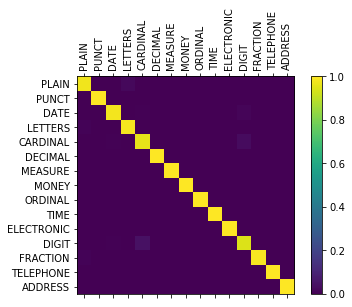

In [205]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000
data_balance_randomize_classes(100000)
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    word_vectors = Variable(torch.from_numpy(s_word_vs))
    string = Variable(string_to_tensor(s_bef))
    if use_cuda:
        word_vectors = word_vectors.cuda()
        string = string.cuda()
    output = model(word_vectors, string)
    guess, guess_i = category_from_output(output)
    category_i = categories_index[s_class]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

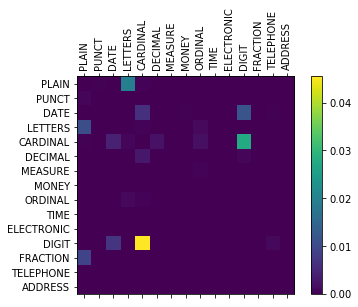

In [234]:
confusion_2 = confusion.clone().numpy()
for i in range(len(confusion_2)):
    confusion_2[i,i]=0

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_2)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()